In [1]:
! pip install git+https://github.com/OpenHydrology/lmoments3.git
! git clone https://github.com/kikocorreoso/scikit-extremes.git
! cd scikit-extremes

import os
os.chdir('scikit-extremes/')

! pip install -e .

  Cloning https://github.com/OpenHydrology/lmoments3.git to /tmp/pip-req-build-yjytpw8s
  Running command git clone --filter=blob:none --quiet https://github.com/OpenHydrology/lmoments3.git /tmp/pip-req-build-yjytpw8s
  Resolved https://github.com/OpenHydrology/lmoments3.git to commit 7e19f97c23019ca68cbd526b8bd417c412438f1c
  Preparing metadata (setup.py) ... done
  Created wheel for lmoments3: filename=lmoments3-1.0.4+9.g7e19f97-py3-none-any.whl size=29092 sha256=33c8c1df4b83d5ea49a46f6b7af42b2395a1a6b2368f5d679646b8cac5785f01
  Stored in directory: /tmp/pip-ephem-wheel-cache-bnu8rwo5/wheels/14/45/9a/545e479c9b488b5f8749469e59bbb12baf971e005b2e81a5f1
Successfully built lmoments3
fatal: destination path 'scikit-extremes' already exists and is not an empty directory.
Obtaining file:///home/jovyan/PlanetaryComputerExamples/Paper3/Paper3/Manuscript_final/scikit-extremes
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.9 MB/s eta 0:00:

In [2]:
import intake
import xarray as xr 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from calendar import monthrange
import numpy as np
import cartopy
from tqdm import tqdm
from scipy import interpolate
import pandas as pd
import seaborn as sns
import os
#%config InlineBackend.figure_format='retina'

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

dataframe (Dataframe) - contains CMIP6 intake json 

In [3]:
historical_year_start = 2000
historical_year_end = 2014

future_year_start = 2086
future_year_end = 2100

In [4]:
parent_dir = '/home/jovyan/PlanetaryComputerExamples/Paper3/Paper3/Manuscript_final/'
#Saving Sr under different scenarios
common_dir = ['Sr_estimates/historical','Sr_estimates/ssp126','Sr_estimates/ssp245','Sr_estimates/ssp370','Sr_estimates/ssp585','Figures']
for dir2 in common_dir:
    try: os.makedirs(os.path.join(parent_dir,dir2))
    except OSError: pass

In [5]:
# necessary url
url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
# open the catalog
dataframe = intake.open_esm_datastore(url)

In [6]:
import warnings
warnings.filterwarnings("ignore")   

CMIP6_datasets = {}
df = {}
for var in ['evspsbl', 'pr']:
    models = dataframe.search(activity_id = ['CMIP','ScenarioMIP'], experiment_id=['historical','ssp126','ssp245','ssp370','ssp585'], variable_id= str(var), member_id='r1i1p1f1', table_id='Amon')
    CMIP6_datasets[str(var)] = models.to_dataset_dict(zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True})
    #---------Extracting the datasets
    keys = []
    for key in CMIP6_datasets[var].keys():
        keys.append(key);
    keys.sort()
    #---------Splitting the dataset in dataframe
    df1 = pd.DataFrame()
    for i in range(len(keys)):
        df2 = {'institution_id': keys[i].split('.')[1],'source_id': keys[i].split('.')[2],'experiment_id': keys[i].split('.')[3],
               'table_id': keys[i].split('.')[4],'grid_label': keys[i].split('.')[5]};
        df1 = df1.append(df2, ignore_index = True);
    df[str(var)] = df1


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [10]:
df = df['evspsbl'][df['evspsbl']['source_id'].isin(df['pr']['source_id'])]

df_final = df.drop_duplicates('source_id').sort_values('source_id').reset_index(drop=True)[['institution_id','source_id','table_id','grid_label']]

df_final['historical'] = 0
df_final['ssp126'] = 0
df_final['ssp245'] = 0
df_final['ssp370'] = 0
df_final['ssp585'] = 0

for model in range(df_final.shape[0]):
    a = df.where((df['source_id'] == df_final.iloc[model,1])).dropna()['experiment_id'].unique()
    if ('historical' in a) == True:
        df_final.iloc[model, 4] = 1
    if ('ssp126' in a) == True:
        df_final.iloc[model, 5] = 1
        if df_final.iloc[model,1] == 'IITM-ESM':
            ## IITM-ESM: Only simulated from 2095-2098
            df_final.iloc[model, 5] = 0
    if ('ssp245' in a) == True:
        df_final.iloc[model, 6] = 1
    if ('ssp370' in a) == True:
        df_final.iloc[model, 7] = 1
        if df_final.iloc[model,1] == 'MPI-ESM-1-2-HAM':
            ## IITM-ESM: Only simulated from 2095-2098
            df_final.iloc[model, 7] = 0
    if ('ssp585' in a) == True:
        df_final.iloc[model, 8] = 1
        if df_final.iloc[model,1] == 'NorESM2-LM':
            # No Precipitation data for NORESM5-ssp585
            df_final.iloc[model, 8] = 0

In [11]:
df_final = df_final[(df_final.source_id != 'EC-Earth3-Veg')]

In [12]:
models_to_remove = np.array(df_final.where((df_final.ssp126==0) & (df_final.ssp245==0) & (df_final.ssp370==0) & (df_final.ssp585 == 0)).dropna()['source_id'])

In [13]:
for model in models_to_remove:
    df_final = df_final[(df_final.source_id != model)]

In [14]:
df_final = df_final.reset_index(drop=True)

In [15]:
df_final

,institution_id,source_id,table_id,grid_label,historical,ssp126,ssp245,ssp370,ssp585
0,CSIRO-ARCCSS,ACCESS-CM2,Amon,gn,1,1,1,1,1
1,CSIRO,ACCESS-ESM1-5,Amon,gn,1,1,0,0,1
2,AWI,AWI-CM-1-1-MR,Amon,gn,1,1,1,1,1
3,BCC,BCC-CSM2-MR,Amon,gn,1,1,1,1,1
4,CAS,CAS-ESM2-0,Amon,gn,1,1,1,1,1
5,NCAR,CESM2-WACCM,Amon,gn,1,1,1,1,1
6,CMCC,CMCC-CM2-SR5,Amon,gn,1,1,1,1,1
7,CMCC,CMCC-ESM2,Amon,gn,1,1,1,1,1
8,CCCma,CanESM5,Amon,gn,1,1,1,1,1
9,E3SM-Project,E3SM-1-1,Amon,gr,1,0,0,0,1


#### To calculate root zone storage capacity (Sr) using monthly precipitation and evaporation dataset

#### Running analysis

In [18]:
def annual_water_deficit_and_Sr_calculation(dataframe):
    SSP = ['historical','ssp126','ssp245','ssp370','ssp585']
    for SSP_ind in SSP:
        df_final = dataframe.where(dataframe[SSP_ind] == 1).dropna()
        for model in tqdm(range(df_final.shape[0])):
            if SSP_ind == 'historical':
                pre_name = 'CMIP.'
                year_start = historical_year_start
                year_end = historical_year_end
            else:
                pre_name = 'ScenarioMIP.'
                year_start = future_year_start
                year_end = future_year_end

            temp_name = str(pre_name)+df_final.iloc[model,0]+'.'+df_final.iloc[model,1]+'.'+str(SSP_ind)+'.'+df_final.iloc[model,2]+'.'+df_final.iloc[model,3]
            if (df_final.iloc[model,0] == 'DKRZ') & (SSP_ind == 'historical'):
                ## MIP-M and DKRZ are same
                temp_name = str(pre_name)+'MPI-M'+'.'+df_final.iloc[model,1]+'.'+str(SSP_ind)+'.'+df_final.iloc[model,2]+'.'+df_final.iloc[model,3]
            if (df_final.iloc[model,1] == 'MPI-ESM1-2-HR')  & (pre_name == 'ScenarioMIP.'):
                temp_name = str(pre_name)+'DKRZ'+'.'+ df_final.iloc[model,1]+'.'+str(SSP_ind)+'.'+df_final.iloc[model,2]+'.'+df_final.iloc[model,3]
            if (df_final.iloc[model,1] == 'IITM-ESM') & (pre_name == 'ScenarioMIP.'):
                ## year end for IITM-ESm is 2099
                year_end = 2099
            if (df_final.iloc[model,1] == 'IITM-ESM') & (pre_name == 'ScenarioMIP.') & (SSP_ind == 'ssp370'):
                ## year end for IITM-ESm is 2099
                year_end = 2098
            print(temp_name+'.'+str(year_start)+'-'+str(year_end))
            
            import os.path
            file_exist = os.path.exists(parent_dir+'/Sr_estimates/'+str(SSP_ind)+'/'+'Sr-20year-return-period.'+temp_name+'.'+str(year_start)+'-'+str(year_end)+'.nc')
            if file_exist == True:
                print('This simulations file exists: Skip')
                continue
            CMIP6_evap = 0
            CMIP6_prec = 0
            CMIP6_evap = (CMIP6_datasets['evspsbl'][temp_name]).sel(time = slice(str(year_start), str(year_end)), lat = slice(-52,52)).evspsbl[0]
            CMIP6_prec = (CMIP6_datasets['pr'][temp_name]).sel(time = slice(str(year_start), str(year_end)), lat = slice(-52,52)).pr[0]

            sum_of_day = []
            year = 0
            for year in range(year_start,year_end+1):
                for month in range(1,13):
                    sum_of_day.append(monthrange(year, month)[1]*(np.ones((CMIP6_evap.shape[1], CMIP6_evap.shape[2])))*86400)
            sum_of_day = (np.array(sum_of_day))

            CMIP6_evap = CMIP6_evap*sum_of_day
            CMIP6_prec = CMIP6_prec*sum_of_day

            CMIP_P_argmax = (CMIP6_prec.groupby('time.month').mean('time'))
            CMIP_P_argmax = CMIP_P_argmax.argmax(axis = 0).values

            deficit_all = (CMIP6_evap) - np.array(CMIP6_prec)
            max_deficit_annual = np.zeros((year_end-year_start,CMIP_P_argmax.shape[0],CMIP_P_argmax.shape[1]))

            year = 0
            for year in (range(year_start,year_end)):
                deficit_all_numpy = deficit_all.sel(time = slice(str(year),str(year+1))).values
                for lat in range(CMIP_P_argmax.shape[0]):
                        for long in range(CMIP_P_argmax.shape[1]):
                            cummul_deficit = np.zeros((24))
                            for i in range(CMIP_P_argmax[lat,long],CMIP_P_argmax[lat,long]+12):
                                cummul_deficit[i] = deficit_all_numpy[i,lat,long] + cummul_deficit[i-1]
                                if cummul_deficit[i] < 0:
                                    cummul_deficit[i] = 0
                                else:
                                    continue
                            max_deficit_annual[year-year_start,lat,long] = np.nanmax(cummul_deficit)

            CMIP6_deficit = xr.DataArray(max_deficit_annual, coords=[np.arange(year_start,year_end,1), CMIP6_evap.lat.values, CMIP6_evap.lon.values],
                         dims=['year', 'lat', 'lon'], name = 'annual_water_deficit', attrs=dict(description="Annual Water Deficit", units="mm/year"))
            #CMIP6_deficit.to_netcdf('CMIP6_annual_deficit_historical/'+'Annual-Water-Deficit.'+str(temp_name)+'.'+str(year_start)+'-'+str(year_end)+'.nc')
            test = np.mean(CMIP6_deficit.values)
            #print(test)
            if np.isnan(test):
                print(name, 'NaN value: ', glob.glob(directory)[name])
            if test == 0:
                print(name, 'Zero value: ', glob.glob(directory)[name])
            print('If no error is shown, dataset is fine')

            import skextremes as ske
            Sr = np.zeros((CMIP6_deficit.values.shape[1], CMIP6_deficit.values.shape[2]))
            for lat in (range(CMIP6_deficit.values.shape[1])):
                for lon in range(CMIP6_deficit.values.shape[2]):
                    WD_cal = (CMIP6_deficit[:,lat,lon].values)
                    model1 = ske.models.classic.Gumbel(WD_cal, fit_method = 'mle', return_periods=20);
                    Sr[lat,lon] = (model1.return_values)
            Sr = xr.DataArray(Sr, coords=[CMIP6_evap.lat.values, CMIP6_evap.lon.values], dims=['lat', 'lon'], name = 'Sr', 
                              attrs=dict(description="Root zone storage capacity", units="mm/year"))
            Sr = Sr.fillna(0)
            Sr.to_netcdf(parent_dir+'/Sr_estimates/'+str(SSP_ind)+'/'+'Sr-20year-return-period.'+temp_name+'.'+str(year_start)+'-'+str(year_end)+'.nc')
            #return Sr

In [20]:
annual_water_deficit_and_Sr_calculation(df_final)

100%|██████████| 33/33 [00:00<00:00, 4350.66it/s]


CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn.2000-2014
This simulations file exists: Skip
CMIP.CSIRO.ACCESS-ESM1-5.historical.Amon.gn.2000-2014
This simulations file exists: Skip
CMIP.AWI.AWI-CM-1-1-MR.historical.Amon.gn.2000-2014
This simulations file exists: Skip
CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn.2000-2014
This simulations file exists: Skip
CMIP.CAS.CAS-ESM2-0.historical.Amon.gn.2000-2014
This simulations file exists: Skip
CMIP.NCAR.CESM2-WACCM.historical.Amon.gn.2000-2014
This simulations file exists: Skip
CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn.2000-2014
This simulations file exists: Skip
CMIP.CMCC.CMCC-ESM2.historical.Amon.gn.2000-2014
This simulations file exists: Skip
CMIP.CCCma.CanESM5.historical.Amon.gn.2000-2014
This simulations file exists: Skip
CMIP.E3SM-Project.E3SM-1-1.historical.Amon.gr.2000-2014
This simulations file exists: Skip
CMIP.EC-Earth-Consortium.EC-Earth3.historical.Amon.gr.2000-2014
This simulations file exists: Skip
CMIP.EC-Earth-Consortium.EC-Eart

100%|██████████| 27/27 [00:00<00:00, 2582.76it/s]


ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp126.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.AWI.AWI-CM-1-1-MR.ssp126.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.BCC.BCC-CSM2-MR.ssp126.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CAS.CAS-ESM2-0.ssp126.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.NCAR.CESM2-WACCM.ssp126.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp126.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CMCC.CMCC-ESM2.ssp126.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CCCma.CanESM5.ssp126.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp126.Amon.gr.2086-2100
This simulations file exists: Skip
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.ssp126.Amon.gr.2086-2100
This simulations fi

100%|██████████| 29/29 [00:00<00:00, 2986.37it/s]


ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp245.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.AWI.AWI-CM-1-1-MR.ssp245.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.BCC.BCC-CSM2-MR.ssp245.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CAS.CAS-ESM2-0.ssp245.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.NCAR.CESM2-WACCM.ssp245.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp245.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CMCC.CMCC-ESM2.ssp245.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CCCma.CanESM5.ssp245.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp245.Amon.gr.2086-2100
This simulations file exists: Skip
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-CC.ssp245.Amon.gr.2086-2100
This simulations file exists: Skip
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.ssp245.Amon.gr.2086-2100
This s

100%|██████████| 27/27 [00:00<00:00, 4192.44it/s]


ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp370.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.AWI.AWI-CM-1-1-MR.ssp370.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.BCC.BCC-CSM2-MR.ssp370.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CAS.CAS-ESM2-0.ssp370.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.NCAR.CESM2-WACCM.ssp370.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp370.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CMCC.CMCC-ESM2.ssp370.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CCCma.CanESM5.ssp370.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp370.Amon.gr.2086-2100
This simulations file exists: Skip
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-AerChem.ssp370.Amon.gr.2086-2100
This simulations file exists: Skip
ScenarioMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.ssp370.Amon.gr.2086-2100
T

100%|██████████| 30/30 [00:00<00:00, 3920.03it/s]

ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.AWI.AWI-CM-1-1-MR.ssp585.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CAS.CAS-ESM2-0.ssp585.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CMCC.CMCC-CM2-SR5.ssp585.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CMCC.CMCC-ESM2.ssp585.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.CCCma.CanESM5.ssp585.Amon.gn.2086-2100
This simulations file exists: Skip
ScenarioMIP.E3SM-Project.E3SM-1-1.ssp585.Amon.gr.2086-2100
This simulations file exists: Skip
ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.Amon.gr.2086-2100
This simulations file exists: Skip

In [18]:
import skextremes as ske
model1 = ske.models.classic.Gumbel(np.arange(0,21,2), fit_method = 'mle', return_periods=20);

In [19]:
model2 = ske.models.classic.Gumbel(np.arange(0,21,1), fit_method = 'mle', return_periods=20);

In [20]:
np.arange(0,21,1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

(<Figure size 800x600 with 4 Axes>,
 <AxesSubplot:title={'center':'Density Plot'}, xlabel='x', ylabel='f(x)'>,
 <AxesSubplot:title={'center':'P-P Plot'}, xlabel='model', ylabel='empirical'>,
 <AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='model', ylabel='empirical'>,
 <AxesSubplot:title={'center':'Return Level Plot'}, xlabel='Return period', ylabel='Return level'>)

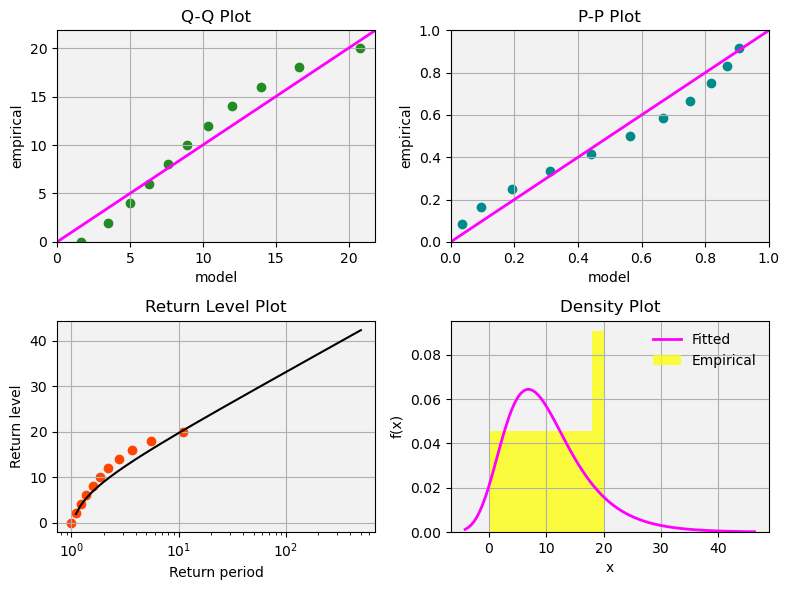

In [21]:
model1.plot_summary()

(<Figure size 800x600 with 4 Axes>,
 <AxesSubplot:title={'center':'Density Plot'}, xlabel='x', ylabel='f(x)'>,
 <AxesSubplot:title={'center':'P-P Plot'}, xlabel='model', ylabel='empirical'>,
 <AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='model', ylabel='empirical'>,
 <AxesSubplot:title={'center':'Return Level Plot'}, xlabel='Return period', ylabel='Return level'>)

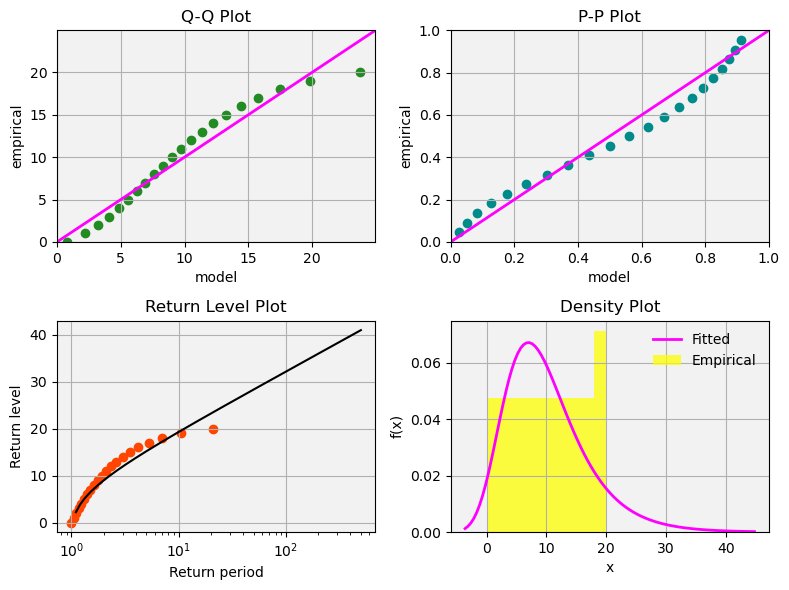

In [22]:
model2.plot_summary()

In [23]:
(model1.return_values)

23.810467708739537

In [24]:
(model2.return_values)

23.245303068353625